# Input data construction for the optimization problem
This notebook constructs the input data required by the optimization problem. It combines real-time API data (electricity, weather, and water usage profiles) to generate consistent and time-aligned inputs for the day-ahead and real-time optimization of the water heating system.

# Libraries 

In [1]:
from datetime import datetime, timedelta
import asyncio
import nest_asyncio
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from forecast_solar import ForecastSolar

# SPOT PRICES

In [2]:
# Tomorrow
tomorrow = datetime.today() + timedelta(days=1)
date_str = tomorrow.strftime("%Y/%m-%d") 
zone = "SE3"
url = f"https://www.elprisetjustnu.se/api/v1/prices/{date_str}_{zone}.json"

# JSON
response = requests.get(url)
data = response.json()

records = []
for hour in data:
    records.append({
        "Time": hour["time_start"],  #  time_start
        "Price_SEK_kWh": hour["SEK_per_kWh"],
        "Price_EUR_kWh": hour["EUR_per_kWh"]
    })

# DataFrame
df_Spot_Prices = pd.DataFrame(records)
df_Spot_Prices["Time"] = pd.to_datetime(df_Spot_Prices["Time"])
df_Spot_Prices = df_Spot_Prices.sort_values("Time").reset_index(drop=True)

# Print the values and some quickstats
display(df_Spot_Prices.head(96))
print(
    "rows:", len(df_Spot_Prices),
    "| min:", df_Spot_Prices["Price_SEK_kWh"].min(),
    "| max:", df_Spot_Prices["Price_SEK_kWh"].max(),
    "| mean:", df_Spot_Prices["Price_SEK_kWh"].mean()
)

,Time,Price_SEK_kWh,Price_EUR_kWh
0,2025-12-16 00:00:00+01:00,0.50145,0.04596
1,2025-12-16 00:15:00+01:00,0.49894,0.04573
2,2025-12-16 00:30:00+01:00,0.49708,0.04556
3,2025-12-16 00:45:00+01:00,0.49217,0.04511
4,2025-12-16 01:00:00+01:00,0.48508,0.04446
...,...,...,...
91,2025-12-16 22:45:00+01:00,0.50254,0.04606
92,2025-12-16 23:00:00+01:00,0.50188,0.04600
93,2025-12-16 23:15:00+01:00,0.49490,0.04536
94,2025-12-16 23:30:00+01:00,0.48999,0.04491


rows: 96 | min: 0.47526 | max: 1.08832 | mean: 0.6432040625000001


# Solar Forecasting

In [3]:
nest_asyncio.apply()

# ---PV forecast (forecast.solar API)---
async def get_solar():
    async with ForecastSolar(latitude=59.33, longitude=18.06,
                             declination=30, azimuth=180, kwp=3.0) as fs:
        est = await fs.estimate()
        d = pd.DataFrame(list(est.watts.items()), columns=["Time","Solar_watt"])
        d["Time"] = pd.to_datetime(d["Time"], utc=True)  
        return d
try:
    df_solar = asyncio.run(get_solar())
except Exception as e:
    raise SystemExit(f"PV API error: {e}")

df_solar["Time"] = df_solar["Time"].dt.tz_convert("Europe/Stockholm")
print("Rows:", len(df_solar))
print(df_solar.head(98))  

Rows: 16
                        Time  Solar_watt
0  2025-12-15 08:38:44+01:00           0
1  2025-12-15 09:00:00+01:00          40
2  2025-12-15 10:00:00+01:00          91
3  2025-12-15 11:00:00+01:00         123
4  2025-12-15 12:00:00+01:00         121
5  2025-12-15 13:00:00+01:00          85
6  2025-12-15 14:00:00+01:00          35
7  2025-12-15 14:47:12+01:00           0
8  2025-12-16 08:39:42+01:00           0
9  2025-12-16 09:00:00+01:00          42
10 2025-12-16 10:00:00+01:00          99
11 2025-12-16 11:00:00+01:00         133
12 2025-12-16 12:00:00+01:00         131
13 2025-12-16 13:00:00+01:00          92
14 2025-12-16 14:00:00+01:00          49
15 2025-12-16 14:47:12+01:00           0


### Light window and filtering 

In [4]:
#Filter only the day after values
TZ   = "Europe/Stockholm"
tomorrow  = pd.Timestamp.now(tz=TZ).normalize() + pd.Timedelta(days=1)
day_after = tomorrow + pd.Timedelta(days=1)

df_solar_day = (df_solar[(df_solar["Time"] >= tomorrow) & (df_solar["Time"] < day_after)]
                  .sort_values("Time").reset_index(drop=True))

#Find the Light window for each day to interpolate the right values and approximate the kW and kWh 
from astral import LocationInfo
from astral.sun import sun

city = LocationInfo("Stockholm", "Sweden", TZ, 59.33, 18.06)
suns = sun(city.observer, date=tomorrow.date(), tzinfo=TZ)
start_light = suns["dawn"]   #  suns["sunrise"]
end_light   = suns["dusk"]   #  suns["sunset"]
print("Light window:", start_light, "→", end_light)

# 15' timeline for each day 
grid = pd.DataFrame({"Time": pd.date_range(tomorrow, day_after, freq="15min",
                                           tz=TZ, inclusive="left")})

# merge
d = pd.merge(grid, df_solar_day, on="Time", how="left")

# 0 outside the light window
d.loc[d["Time"] < start_light, "Solar_watt"] = 0.0
d.loc[d["Time"] > end_light,   "Solar_watt"] = 0.0

# Interpolate onlyy inside the light window
mask = (d["Time"] >= start_light) & (d["Time"] <= end_light)
d.loc[mask, "Solar_watt"] = d.loc[mask, "Solar_watt"].interpolate(method="linear")

# filtering
d["Solar_watt"] = d["Solar_watt"].fillna(0.0).clip(lower=0.0)
d["Solar_kWh_15min"] = d["Solar_watt"]/1000.0 * 0.25

df_solar_15 = d
print("Solar 15min rows:", len(df_solar_15))
print(df_solar_15.head(), df_solar_15.tail(), sep="\n\n")

Light window: 2025-12-16 07:43:54.144163+01:00 → 2025-12-16 15:42:55.661659+01:00
Solar 15min rows: 96
                       Time  Solar_watt  Solar_kWh_15min
0 2025-12-16 00:00:00+01:00         0.0              0.0
1 2025-12-16 00:15:00+01:00         0.0              0.0
2 2025-12-16 00:30:00+01:00         0.0              0.0
3 2025-12-16 00:45:00+01:00         0.0              0.0
4 2025-12-16 01:00:00+01:00         0.0              0.0

                        Time  Solar_watt  Solar_kWh_15min
91 2025-12-16 22:45:00+01:00         0.0              0.0
92 2025-12-16 23:00:00+01:00         0.0              0.0
93 2025-12-16 23:15:00+01:00         0.0              0.0
94 2025-12-16 23:30:00+01:00         0.0              0.0
95 2025-12-16 23:45:00+01:00         0.0              0.0


In [5]:
# ---Merge Spot Prices and Solar---

prices = df_Spot_Prices[["Time", "Price_SEK_kWh"]].sort_values("Time")

df_combined = (pd.merge(prices, df_solar_15, on="Time", how="left")
                 .fillna({"Solar_watt":0.0, "Solar_kWh_15min":0.0})
                 .reset_index(drop=True))

print("Rows:", len(df_combined))    #Always 96
print(df_combined.head(5)); print(df_combined.tail(5))

#Total Solar Production (kWh)
total_solar_kwh = df_combined["Solar_kWh_15min"].sum()
print("Total Solar Production (kWh):", total_solar_kwh)

Rows: 96
                       Time  Price_SEK_kWh  Solar_watt  Solar_kWh_15min
0 2025-12-16 00:00:00+01:00        0.50145         0.0              0.0
1 2025-12-16 00:15:00+01:00        0.49894         0.0              0.0
2 2025-12-16 00:30:00+01:00        0.49708         0.0              0.0
3 2025-12-16 00:45:00+01:00        0.49217         0.0              0.0
4 2025-12-16 01:00:00+01:00        0.48508         0.0              0.0
                        Time  Price_SEK_kWh  Solar_watt  Solar_kWh_15min
91 2025-12-16 22:45:00+01:00        0.50254         0.0              0.0
92 2025-12-16 23:00:00+01:00        0.50188         0.0              0.0
93 2025-12-16 23:15:00+01:00        0.49490         0.0              0.0
94 2025-12-16 23:30:00+01:00        0.48999         0.0              0.0
95 2025-12-16 23:45:00+01:00        0.48235         0.0              0.0
Total Solar Production (kWh): 0.585375


### Plotting of Spot prices and Solar forecasting of the next day

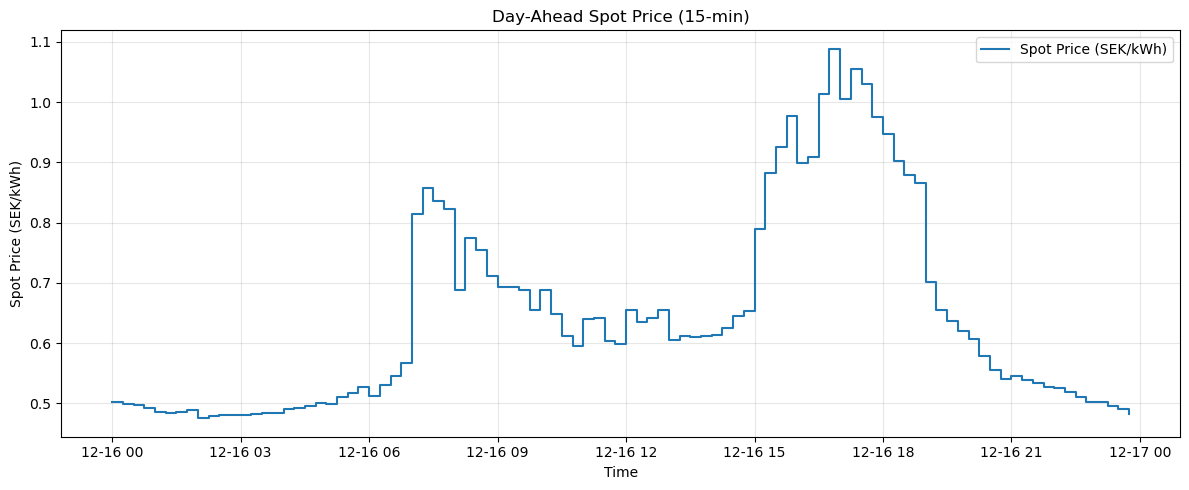

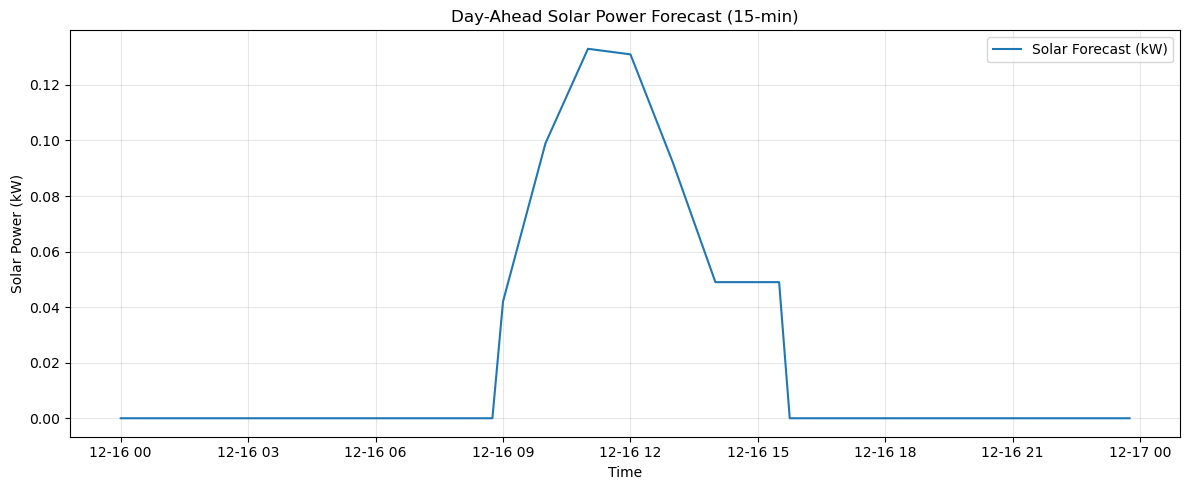

In [6]:
# ---FIGURE 1: Spot Price---
plt.figure(figsize=(12,5))
plt.step(
    df_combined["Time"],
    df_combined["Price_SEK_kWh"],
    where="post",
    label="Spot Price (SEK/kWh)",
)
plt.ylabel("Spot Price (SEK/kWh)")
plt.xlabel("Time")
plt.title("Day-Ahead Spot Price (15-min)")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


# ---FIGURE 2: Solar Forecast---
plt.figure(figsize=(12,5))
plt.plot(
    df_combined["Time"],
    df_combined["Solar_watt"]/1000.0,
    label="Solar Forecast (kW)",
)
plt.ylabel("Solar Power (kW)")
plt.xlabel("Time")
plt.title("Day-Ahead Solar Power Forecast (15-min)")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()



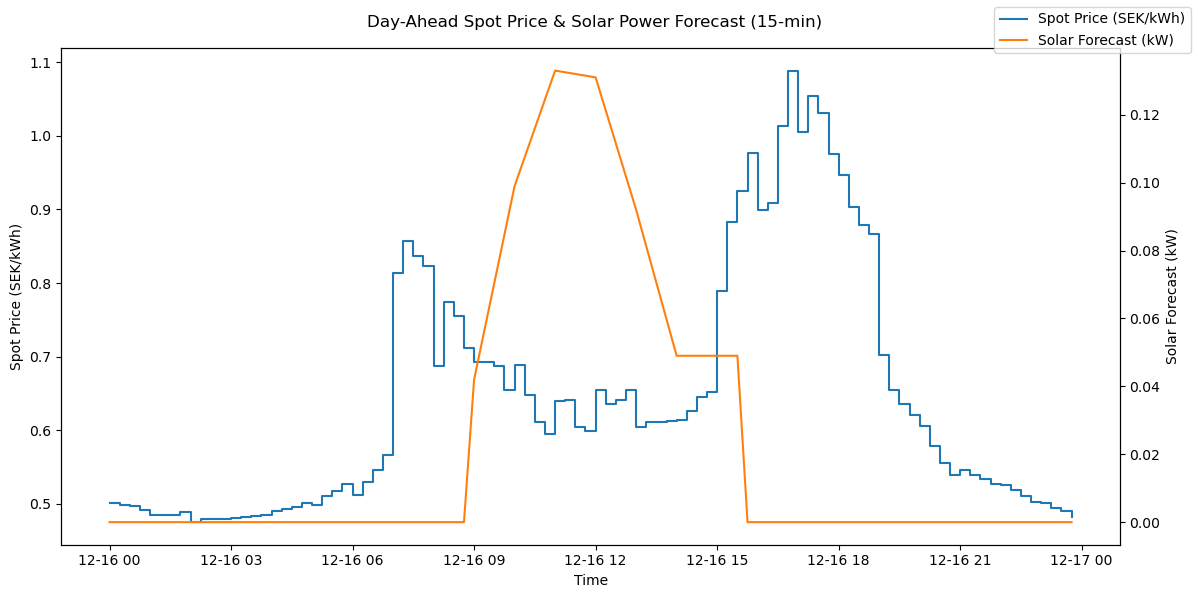

In [7]:
# --- Day-Ahead Spot Price & Solar Power Forecast are plotted together---
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Spot Price (SEK/kWh)")
ax1.step(df_combined["Time"], df_combined["Price_SEK_kWh"],
         where="post", color='tab:blue', label="Spot Price (SEK/kWh)")

ax2 = ax1.twinx()
ax2.set_ylabel("Solar Forecast (kW)")
ax2.plot(df_combined["Time"], df_combined["Solar_watt"]/1000.0,
         color='tab:orange', label="Solar Forecast (kW)")

fig.suptitle("Day-Ahead Spot Price & Solar Power Forecast (15-min)")
fig.legend(loc="upper right")
plt.tight_layout(); plt.show()

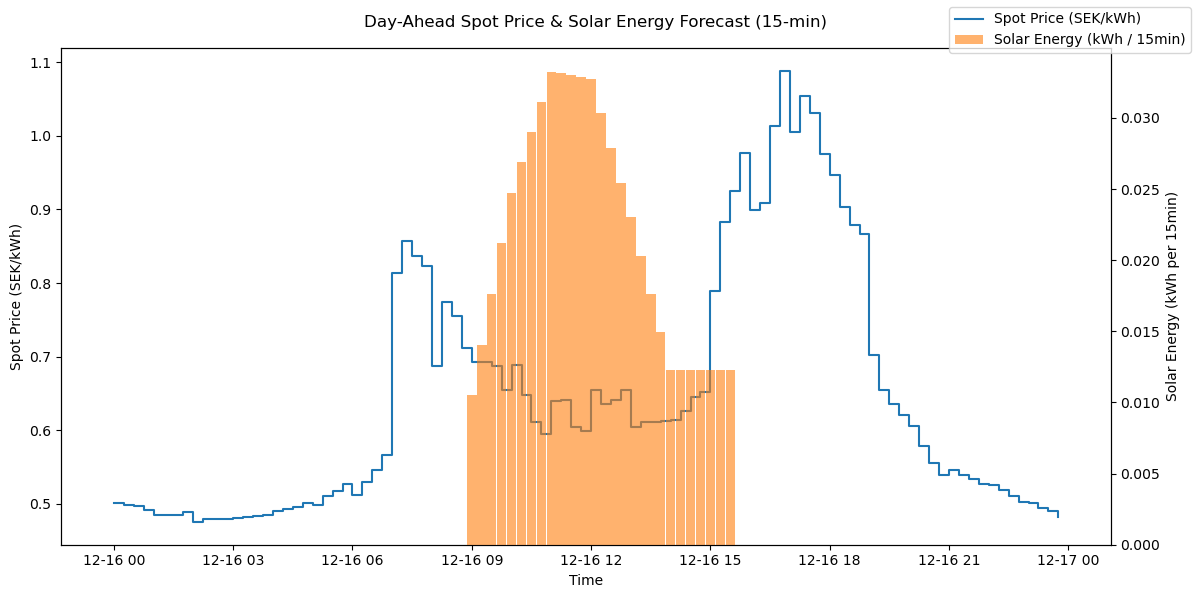

In [8]:
# --- Day-Ahead Spot Price & Solar Energy Forecast are plotted together---
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Spot Price (SEK/kWh)")
ax1.step(df_combined["Time"], df_combined["Price_SEK_kWh"],
         where="post", color='tab:blue', label="Spot Price (SEK/kWh)")

ax2 = ax1.twinx()
ax2.set_ylabel("Solar Energy (kWh per 15min)")
ax2.bar(df_combined["Time"], df_combined["Solar_kWh_15min"],
        width=0.01, color='tab:orange', alpha=0.6, label="Solar Energy (kWh / 15min)")

fig.suptitle("Day-Ahead Spot Price & Solar Energy Forecast (15-min)")
fig.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Water Usage Profile 

In [9]:
PULSE_L = 0.002 # liters per pulse
TZ = "Europe/Stockholm"
START = "2023-05-08"
END   = "2024-05-08"

# --- Load CSV with raw meter data ---
df = pd.read_csv(
    "/Users/iraklisbournazos/Downloads/water_data.csv",
    header=None,
    names=["timestamp","pulses","flow_ml_s"],
    on_bad_lines='skip'
)

# timestamps -> datetime Europe/Stockholm
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s", utc=True).dt.tz_convert(TZ)
# Sorting and drop duplicates
df = (df.sort_values("datetime")
        .drop_duplicates("datetime", keep="last")
        .reset_index(drop=True))

# keep only desired period (1 year)
start = pd.Timestamp(START, tz=TZ)
end   = pd.Timestamp(END, tz=TZ) + pd.Timedelta(days=1)
df = df[(df["datetime"] >= start) & (df["datetime"] < end)].copy()

# Convert pulses (cumulative counter) -> liters per sample
# diff() turns the cumulative counter into per-sample increments
# clip(lower=0) protects against counter resets (negative diffs)
delta_pulses = df["pulses"].diff().clip(lower=0).fillna(0)
df["delta_L"] = delta_pulses * PULSE_L

# Daily aggregation (total liters per day)
daily = df.set_index("datetime")["delta_L"].resample("D").sum().to_frame("daily_L")

# Monthly totals (sum of daily)
monthly = daily.resample("MS").sum().rename(columns={"daily_L":"monthly_L"})

# Quick stats
print("Range:", daily.index.min(), "→", daily.index.max())
print("Total L:", round(daily["daily_L"].sum(), 1))
print("\nDaily head:\n", daily.head(12))
print("\nMonthly head:\n", monthly.head(12))

Range: 2023-05-08 00:00:00+02:00 → 2024-05-08 00:00:00+02:00
Total L: 125240.4

Daily head:
                            daily_L
datetime                          
2023-05-08 00:00:00+02:00   21.846
2023-05-09 00:00:00+02:00  439.070
2023-05-10 00:00:00+02:00  550.060
2023-05-11 00:00:00+02:00  528.932
2023-05-12 00:00:00+02:00  392.608
2023-05-13 00:00:00+02:00  444.294
2023-05-14 00:00:00+02:00  403.474
2023-05-15 00:00:00+02:00  459.830
2023-05-16 00:00:00+02:00  539.768
2023-05-17 00:00:00+02:00  412.226
2023-05-18 00:00:00+02:00  354.014
2023-05-19 00:00:00+02:00  420.712

Monthly head:
                            monthly_L
datetime                            
2023-05-01 00:00:00+02:00   9148.998
2023-06-01 00:00:00+02:00   8751.720
2023-07-01 00:00:00+02:00   7229.054
2023-08-01 00:00:00+02:00   9757.070
2023-09-01 00:00:00+02:00   8408.444
2023-10-01 00:00:00+02:00  10000.450
2023-11-01 00:00:00+01:00   9650.882
2023-12-01 00:00:00+01:00  11808.250
2024-01-01 00:00:00+01:00  1299

In [10]:

# ---Resample in 15minutes and in Liters---
df_15 = df.set_index("datetime")["delta_L"].resample("15T").sum().to_frame("L")

# ---Time columns (00:00–23:45)---
df_15["time_of_day"] = df_15.index.time

# ---mean per time block (96 blocks per day)---
mean_profile = df_15.groupby("time_of_day")["L"].mean()

#Liters in kWh
kwh_per_liter = 4.186 * 50 / 3600  # ≈ 0.0581 kWh per liter

df_energy = (mean_profile * kwh_per_liter).to_frame(name="kWh_per_15min")
df_energy.head()

/var/folders/cj/hstcg8jj049d692w5pbvkbs00000gn/T/ipykernel_11473/3220320671.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15 = df.set_index("datetime")["delta_L"].resample("15T").sum().to_frame("L")


,kWh_per_15min
time_of_day,
00:00:00,0.271492
00:15:00,0.370811
00:30:00,0.292644
00:45:00,0.296855
01:00:00,0.292609


# Load forecasting for the next day

In [11]:
df_load = pd.read_csv("/Users/iraklisbournazos/Desktop/FINAL REPORT PROJECT/predicted_load_24h.csv", parse_dates=["Time"])
df_load["Time"] = pd.to_datetime(df_load["Time"]) 

df_combined["Time"] = pd.to_datetime(df_combined["Time"])
df_all = pd.merge(df_combined, df_load, on="Time", how="left")
print(df_all[["Time","Price_SEK_kWh","Solar_watt","Pin_pred_W"]].head(50))

                        Time  Price_SEK_kWh  Solar_watt   Pin_pred_W
0  2025-12-16 00:00:00+01:00        0.50145        0.00  3517.599887
1  2025-12-16 00:15:00+01:00        0.49894        0.00  3536.655707
2  2025-12-16 00:30:00+01:00        0.49708        0.00  3555.711527
3  2025-12-16 00:45:00+01:00        0.49217        0.00  3574.767347
4  2025-12-16 01:00:00+01:00        0.48508        0.00  3593.823167
5  2025-12-16 01:15:00+01:00        0.48475        0.00  3544.319834
6  2025-12-16 01:30:00+01:00        0.48519        0.00  3494.816502
7  2025-12-16 01:45:00+01:00        0.48857        0.00  3445.313169
8  2025-12-16 02:00:00+01:00        0.47526        0.00  3395.809837
9  2025-12-16 02:15:00+01:00        0.47897        0.00  3511.235388
10 2025-12-16 02:30:00+01:00        0.48006        0.00  3626.660939
11 2025-12-16 02:45:00+01:00        0.48017        0.00  3742.086491
12 2025-12-16 03:00:00+01:00        0.48072        0.00  3857.512042
13 2025-12-16 03:15:00+01:00      

# Plots

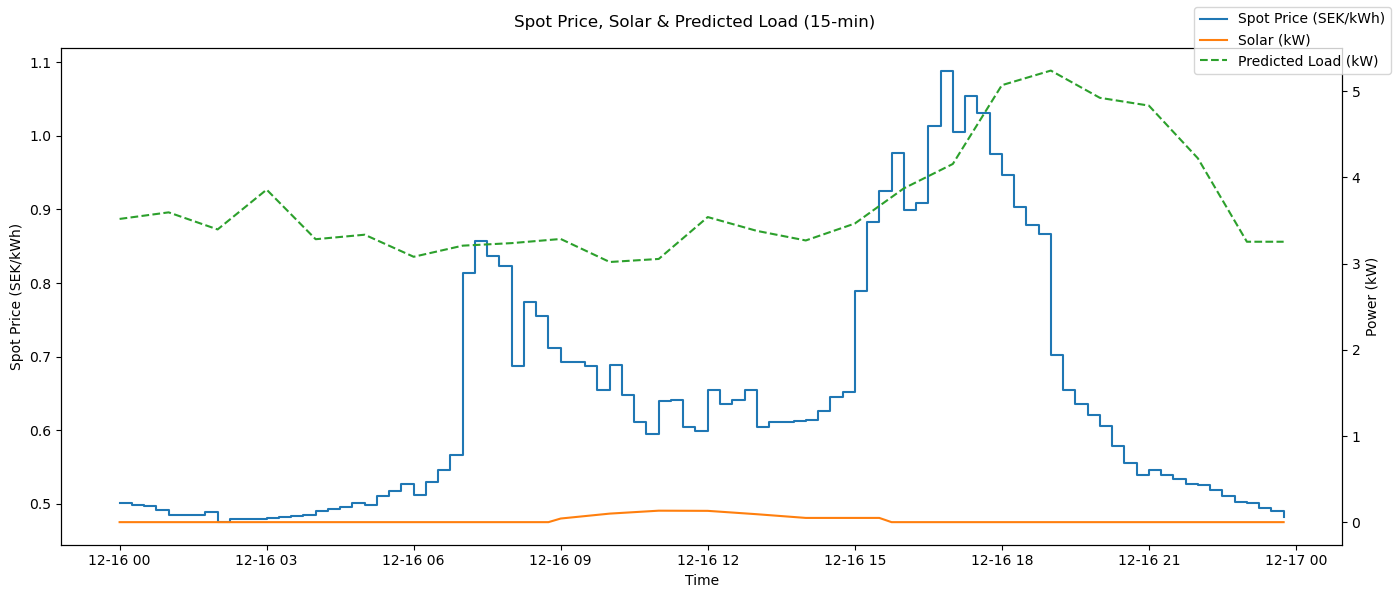

In [12]:
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Spot Price (SEK/kWh)")
ax1.step(df_all["Time"], df_all["Price_SEK_kWh"], where="post",
         color='tab:blue', label="Spot Price (SEK/kWh)")

ax2 = ax1.twinx()
ax2.set_ylabel("Power (kW)")
ax2.plot(df_all["Time"], df_all["Solar_watt"]/1000.0,
         color='tab:orange', label="Solar (kW)")
ax2.plot(df_all["Time"], df_all["Pin_pred_W"]/1000.0,
         color='tab:green', linestyle='--', label="Predicted Load (kW)")

fig.suptitle("Spot Price, Solar & Predicted Load (15-min)")
fig.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [13]:
step_hours = 0.25

df_all["Solar_kWh"]     = (df_all["Solar_watt"]   / 1000.0) * step_hours
df_all["Pin_pred_kWh"]  = (df_all["Pin_pred_W"]   / 1000.0) * step_hours
display(df_all[["Time","Price_SEK_kWh","Solar_watt","Pin_pred_W","Solar_kWh","Pin_pred_kWh"]].head(50))

,Time,Price_SEK_kWh,Solar_watt,Pin_pred_W,Solar_kWh,Pin_pred_kWh
0,2025-12-16 00:00:00+01:00,0.50145,0.00,3517.599887,0.000000,0.879400
1,2025-12-16 00:15:00+01:00,0.49894,0.00,3536.655707,0.000000,0.884164
2,2025-12-16 00:30:00+01:00,0.49708,0.00,3555.711527,0.000000,0.888928
3,2025-12-16 00:45:00+01:00,0.49217,0.00,3574.767347,0.000000,0.893692
4,2025-12-16 01:00:00+01:00,0.48508,0.00,3593.823167,0.000000,0.898456
5,2025-12-16 01:15:00+01:00,0.48475,0.00,3544.319834,0.000000,0.886080
6,2025-12-16 01:30:00+01:00,0.48519,0.00,3494.816502,0.000000,0.873704
7,2025-12-16 01:45:00+01:00,0.48857,0.00,3445.313169,0.000000,0.861328
8,2025-12-16 02:00:00+01:00,0.47526,0.00,3395.809837,0.000000,0.848952
9,2025-12-16 02:15:00+01:00,0.47897,0.00,3511.235388,0.000000,0.877809


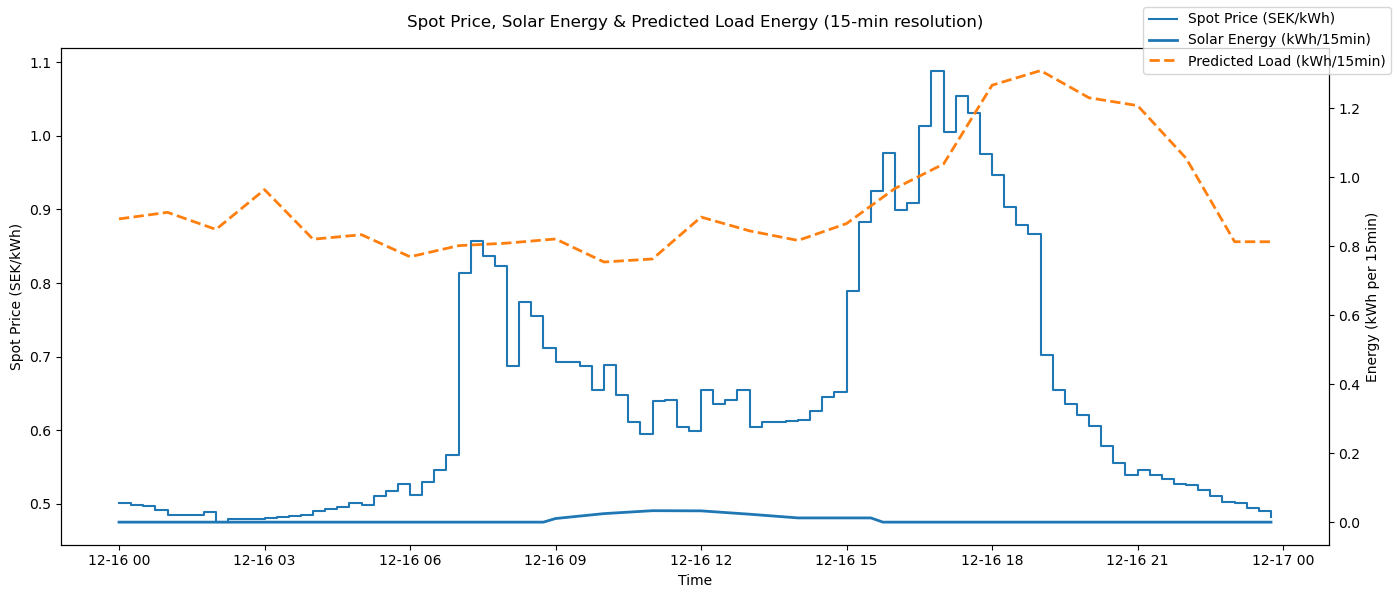

In [14]:
fig, ax1 = plt.subplots(figsize=(14,6))

# ---Spot Price---
ax1.set_xlabel("Time")
ax1.set_ylabel("Spot Price (SEK/kWh)")
ax1.step(df_all["Time"], df_all["Price_SEK_kWh"], where="post",
         color='tab:blue', label="Spot Price (SEK/kWh)")

# ---Solar + Load energy in kWh (secondary axis)---
ax2 = ax1.twinx()
ax2.set_ylabel("Energy (kWh per 15min)")

# Plot energy per step
ax2.plot(df_all["Time"], df_all["Solar_kWh"],
         label="Solar Energy (kWh/15min)", linewidth=2)

ax2.plot(df_all["Time"], df_all["Pin_pred_kWh"],
         label="Predicted Load (kWh/15min)", linestyle="--", linewidth=2)

fig.suptitle("Spot Price, Solar Energy & Predicted Load Energy (15-min resolution)")
fig.legend(loc="upper right")
plt.tight_layout()
plt.show()


# Final data that are used for the optimization model with some plots

In [15]:
# Add boiler energy column directly (same length, same ordering)
df_all["Boiler_kWh_per_15min"] = df_energy["kWh_per_15min"].values

# Compute load minus boiler in order to catch the possible solar surplus
df_all["Load_minus_Boiler_kWh"] = df_all["Pin_pred_kWh"] - df_all["Boiler_kWh_per_15min"]



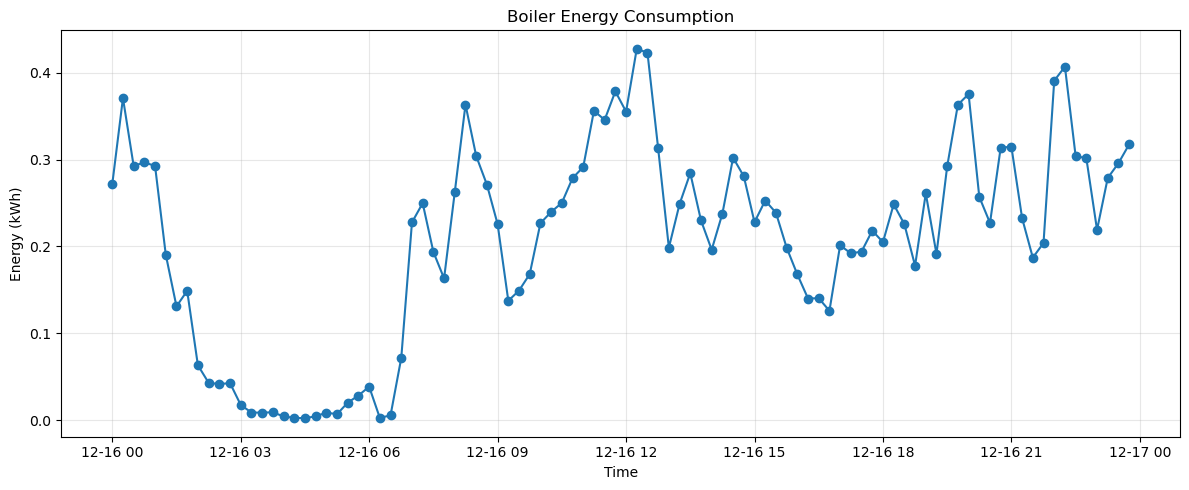

In [16]:
plt.figure(figsize=(12,5))
plt.plot(df_all["Time"], df_all["Boiler_kWh_per_15min"], marker="o")
plt.title("Boiler Energy Consumption")
plt.xlabel("Time")
plt.ylabel("Energy (kWh)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [17]:
df_all

,Time,Price_SEK_kWh,Solar_watt,Solar_kWh_15min,Pin_pred_W,Solar_kWh,Pin_pred_kWh,Boiler_kWh_per_15min,Load_minus_Boiler_kWh
0,2025-12-16 00:00:00+01:00,0.50145,0.0,0.0,3517.599887,0.0,0.879400,0.271492,0.607908
1,2025-12-16 00:15:00+01:00,0.49894,0.0,0.0,3536.655707,0.0,0.884164,0.370811,0.513353
2,2025-12-16 00:30:00+01:00,0.49708,0.0,0.0,3555.711527,0.0,0.888928,0.292644,0.596284
3,2025-12-16 00:45:00+01:00,0.49217,0.0,0.0,3574.767347,0.0,0.893692,0.296855,0.596837
4,2025-12-16 01:00:00+01:00,0.48508,0.0,0.0,3593.823167,0.0,0.898456,0.292609,0.605847
...,...,...,...,...,...,...,...,...,...
91,2025-12-16 22:45:00+01:00,0.50254,0.0,0.0,3494.981214,0.0,0.873745,0.301601,0.572144
92,2025-12-16 23:00:00+01:00,0.50188,0.0,0.0,3253.038312,0.0,0.813260,0.219070,0.594190
93,2025-12-16 23:15:00+01:00,0.49490,0.0,0.0,3253.038312,0.0,0.813260,0.278820,0.534439
94,2025-12-16 23:30:00+01:00,0.48999,0.0,0.0,3253.038312,0.0,0.813260,0.295844,0.517416


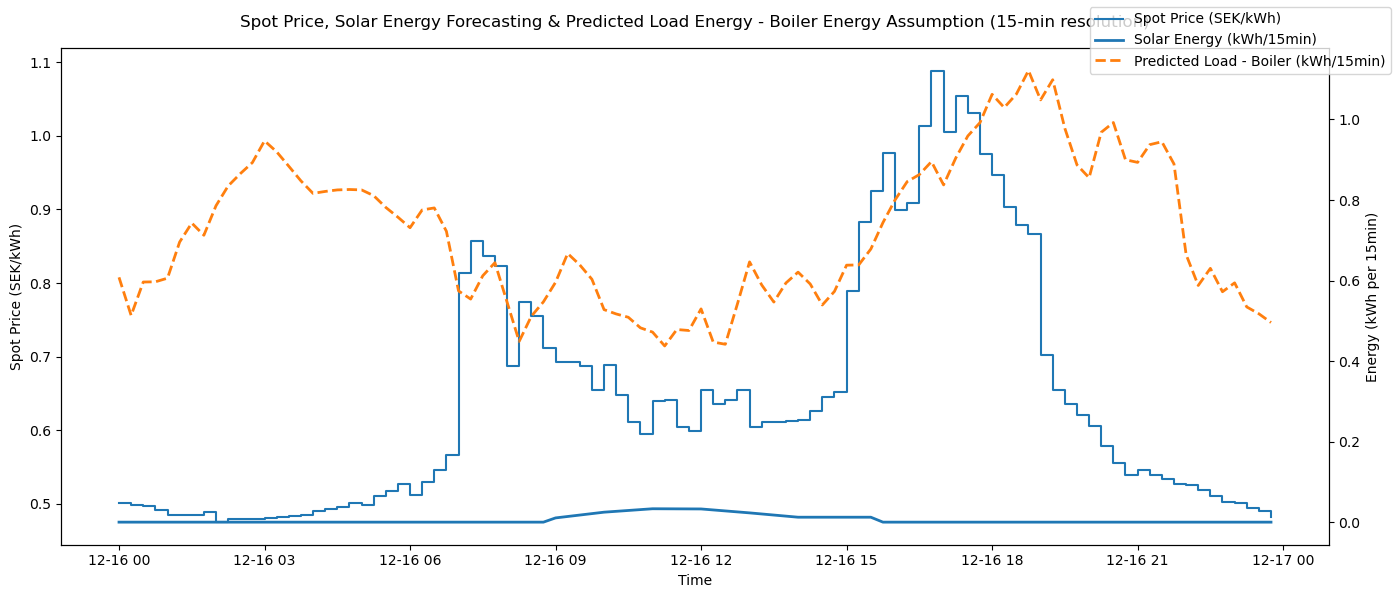

In [18]:
fig, ax1 = plt.subplots(figsize=(14,6))

# === Spot Price (on primary y-axis - left) ===
ax1.set_xlabel("Time")
ax1.set_ylabel("Spot Price (SEK/kWh)")
ax1.step(df_all["Time"], df_all["Price_SEK_kWh"], where="post",
         color='tab:blue', label="Spot Price (SEK/kWh)")

# === Solar + Load energy in kWh (secondary axis) ===
ax2 = ax1.twinx()
ax2.set_ylabel("Energy (kWh per 15min)")

# Plot energy per step
ax2.plot(df_all["Time"], df_all["Solar_kWh"],
         label="Solar Energy (kWh/15min)", linewidth=2)

ax2.plot(df_all["Time"], df_all["Load_minus_Boiler_kWh"],
         label="Predicted Load - Boiler (kWh/15min)", linestyle="--", linewidth=2)

fig.suptitle("Spot Price, Solar Energy Forecasting & Predicted Load Energy - Boiler Energy Assumption (15-min resolution)")
fig.legend(loc="upper right")
plt.tight_layout()
plt.show()

# CSV with imput data that is used for the optimization process

In [19]:
df_all.to_csv("df_all_from_partb.csv", index=False)
print("Saved df_all_from_partb.csv")


Saved df_all_from_partb.csv


### Sanity check

In [20]:
df_check = pd.read_csv("df_all_from_partb.csv")

print(df_check.isna().sum())
print("Any NaN? ->", df_check.isna().any().any())


Time                     0
Price_SEK_kWh            0
Solar_watt               0
Solar_kWh_15min          0
Pin_pred_W               0
Solar_kWh                0
Pin_pred_kWh             0
Boiler_kWh_per_15min     0
Load_minus_Boiler_kWh    0
dtype: int64
Any NaN? -> False
